# TSE(R,S) analysis for time evolving systems

Content:
- Functions to obtain information metrics (R,S,TSE) per sliding timewindow for a given timeseries
- Example of TSE evolution for one system
- Results of TSE evolution for large number of systems

In [64]:
import infotopo_no_prints
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.animation as animation
from sklearn.utils import Bunch
from scipy.integrate import solve_ivp

In [4]:
# Define functions

# Normalize the first two columns individually for a given dataframe (range 0-1)
def normalize_columns(df):
    # Normalize first column (index 0)
    min_x, max_x = df.iloc[:, 0].min(), df.iloc[:, 0].max()
    df.iloc[:, 0] = (df.iloc[:, 0] - min_x) / (max_x - min_x) if max_x != min_x else 0
    
    # Normalize second column (index 1)
    min_y, max_y = df.iloc[:, 1].min(), df.iloc[:, 1].max()
    df.iloc[:, 1] = (df.iloc[:, 1] - min_y) / (max_y - min_y) if max_y != min_y else 0
    
    return df

# Optimized function to compute TSE complexity
def compute_tse_complexity(TC_dict):
    """
    Computes the TSE complexity given a dictionary of total correlations.
    
    Parameters:
        TC_dict (dict): Dictionary of total correlations where keys are tuples (subsets).
        
    Returns:
        float: The TSE complexity.
    """
    N = max(len(subset) for subset in TC_dict)  # Maximum subset size
    TSE = 0
    for gamma in range(1, N):
        TC_full = (gamma / N) * TC_dict[tuple(range(1, N + 1))]
        E_TC_gamma = np.mean([TC_dict[subset] for subset in TC_dict if len(subset) == gamma])
        TSE += TC_full - E_TC_gamma
    return TSE

# Convert pandas dataframe to bunch object
def dataframe_to_bunch(dataframe, target=None, feature_names=None, target_names=None, descr="Custom dataset"):
    if feature_names is None:
        feature_names = dataframe.columns.tolist()
    
    return Bunch(
        data=dataframe.to_numpy(),
        target=target if target is not None else np.zeros(dataframe.shape[0]),
        feature_names=feature_names,
        target_names=target_names if target_names is not None else ["target"],
        DESCR=descr
    )

# Obtain topological information metrics using infotopo
def obtain_infotopo_metrics(dataset, dimension_max=0, dimension_tot=0):

    if dimension_max == 0:
        dimension_max = 3 #dataset.shape[1]
    if dimension_tot == 0:
        dimension_tot = 9 #dataset.shape[1]
    
    sample_size = dataset.shape[0]
    nb_of_values = 16
    forward_computation_mode = True
    work_on_transpose = False
    supervised_mode = False
    sampling_mode = 1
    deformed_probability_mode = False

    information_topo = infotopo_no_prints.infotopo(dimension_max = dimension_max,
                                dimension_tot = dimension_tot,
                                sample_size = sample_size,
                                work_on_transpose = work_on_transpose,
                                nb_of_values = nb_of_values,
                                sampling_mode = sampling_mode,
                                deformed_probability_mode = deformed_probability_mode,
                                supervised_mode = supervised_mode,
                                forward_computation_mode = forward_computation_mode)
    
    Nentropie = information_topo.simplicial_entropies_decomposition(dataset)
    Ninfomut = information_topo.simplicial_infomut_decomposition(Nentropie)
    Nfree_energy = information_topo.total_correlation_simplicial_lanscape(Nentropie)
    
    return  Nentropie, Ninfomut, Nfree_energy

# Function to compute metrics for a time window sliding over a given timeseries
def interactions_values_dominance(df_input, window_size=0, window_step=0, dimension_max=0, dimension_tot=0):
    # Initialize an empty DataFrame
    columns = ['R_sum', 'S_sum', 'TSE_value']
    df_output = pd.DataFrame(columns=columns)

    # Set initial window conditions
    if window_size == 0:
        window_size = len(df_input)-1
    if window_step == 0:
        window_step = 1
    window_start = 0
    window_end = window_start + window_size

    while window_end < len(df_input):
        bunch_data = dataframe_to_bunch(df_input.iloc[window_start:window_end])
        Nentropie, Ninfomut, Nfree_energy = obtain_infotopo_metrics(bunch_data.data, dimension_max, dimension_tot)
        #Ninfomut = coarse_grain_with_xgi(Ninfomut, 4)
        S_sum = sum(value for key, value in Ninfomut.items() if len(key) > 2 and value < 0)
        R_sum = sum(value for key, value in Ninfomut.items() if len(key) > 2 and value > 0)
        TSE_value = compute_tse_complexity(Nfree_energy)

        # Add the new values to the dataframe
        new_row = pd.DataFrame({'R_sum': [R_sum], 'S_sum': [S_sum], 'TSE_value': [TSE_value]})
        df_output = pd.concat([df_output, new_row], ignore_index=True)
        
        window_start += window_step
        window_end += window_step

    # Normalize and absolutize all the values so that the S and R values are all positive and the maximum R and S are 1.
    df_output.iloc[:, 1] = df_output.iloc[:, 1] * -1

    max_R = df_output.iloc[:, 0].max()
    max_S = df_output.iloc[:, 1].max()

    if max_S > 0:
        df_output.iloc[:, 1] = df_output.iloc[:, 1] / max_S        
    if max_R > 0:
        df_output.iloc[:, 0] = df_output.iloc[:, 0] / max_R

    return df_output

# Function to compute metrics for a time window sliding over a given timeseries
def interactions_values_relative(df_input, window_size=0, window_step=0, dimension_max=0, dimension_tot=0):
    # Initialize an empty DataFrame
    columns = ['R_sum', 'S_sum', 'TSE_value']
    df_output = pd.DataFrame(columns=columns)

    # Set initial window conditions
    if window_size == 0:
        window_size = len(df_input)-1
    if window_step == 0:
        window_step = 1
    window_start = 0
    window_end = window_start + window_size

    while window_end < len(df_input):
        bunch_data = dataframe_to_bunch(df_input.iloc[window_start:window_end])
        Nentropie, Ninfomut, Nfree_energy = obtain_infotopo_metrics(bunch_data.data, dimension_max, dimension_tot)

        MI_sum = sum(Ninfomut.values())
        TC_sum = sum(Nfree_energy.values())
        S_sum = (TC_sum-MI_sum)/2
        R_sum = -(TC_sum+MI_sum)/2
        TSE_value = compute_tse_complexity(Nfree_energy)

        # Add the new values to the dataframe
        new_row = pd.DataFrame({'R_sum': [R_sum], 'S_sum': [S_sum], 'TSE_value': [TSE_value]})
        df_output = pd.concat([df_output, new_row], ignore_index=True)
        
        window_start += window_step
        window_end += window_step

    # Normalize all the values so that the S and R values are all positive and the maximum R and S are 1 and minimum 0.
    min_R = df_output.iloc[:, 0].min()
    df_output.iloc[:, 0] += abs(min_R)

    df_output['S_sum'] = (df_output['S_sum'] - df_output['S_sum'].min()) / (df_output['S_sum'].max() - df_output['S_sum'].min())
    df_output['R_sum'] = (df_output['R_sum'] - df_output['R_sum'].min()) / (df_output['R_sum'].max() - df_output['R_sum'].min())

    return df_output

# Kuramoto model differential equation
def kuramoto(t, theta, omega, K, N):
    dtheta = np.zeros(N)
    for i in range(N):
        interaction = np.sum(np.sin(theta - theta[i]))
        dtheta[i] = omega[i] + (K / N) * interaction
    return dtheta

# Simulate the Kuramoto model and save frequency time series
def simulate_kuramoto(N=5, K=1.0, T=10, dt=0.01):
    # Initialize random natural frequencies and initial phases
    omega = np.random.normal(loc=0, scale=1, size=N)
    initial_phases = np.random.uniform(0, 2 * np.pi, N)
    
    # Time vector
    t_eval = np.arange(0, T, dt)
    
    # Solve the system
    sol = solve_ivp(kuramoto, [0, T], initial_phases, args=(omega, K, N), t_eval=t_eval, method='RK45')
    
    # Compute instantaneous frequencies (time derivative of phases)
    frequencies = np.gradient(sol.y, sol.t, axis=1)
    
    return sol, omega, frequencies

In [5]:
# Function to compute metrics for a time window sliding over a given timeseries
def interactions_values_relative(df_input, window_size=0, window_step=0, dimension_max=0, dimension_tot=0):
    # Initialize an empty DataFrame
    columns = ['R_sum', 'S_sum', 'TSE_value', 'R_values', 'S_values']
    df_output = pd.DataFrame(columns=columns)

    # Set initial window conditions
    if window_size == 0:
        window_size = len(df_input)-1
    if window_step == 0:
        window_step = 1
    window_start = 0
    window_end = window_start + window_size

    while window_end < len(df_input):
        bunch_data = dataframe_to_bunch(df_input.iloc[window_start:window_end])
        Nentropie, Ninfomut, Nfree_energy = obtain_infotopo_metrics(bunch_data.data, dimension_max, dimension_tot)

        S_values = [(TC - MI) / 2 for TC, MI in zip(Nfree_energy.values(), Ninfomut.values())]
        R_values = [-(TC + MI) / 2 for TC, MI in zip(Nfree_energy.values(), Ninfomut.values())]
        S_sum = sum(S_values)
        R_sum = sum(R_values)
        TSE_value = compute_tse_complexity(Nfree_energy)

        # Add the new values to the dataframe
        new_row = pd.DataFrame({'R_sum': [R_sum], 'S_sum': [S_sum], 'TSE_value': [TSE_value], 'R_values': [R_values], 'S_values':[S_values]})
        df_output = pd.concat([df_output, new_row], ignore_index=True)
        
        window_start += window_step
        window_end += window_step

    # Normalize all the values so that the S and R values are all positive and the maximum R and S are 1 and minimum 0.
    min_R = df_output.iloc[:, 0].min()
    df_output.iloc[:, 0] += abs(min_R)

    df_output['S_sum'] = (df_output['S_sum'] - df_output['S_sum'].min()) / (df_output['S_sum'].max() - df_output['S_sum'].min())
    df_output['R_sum'] = (df_output['R_sum'] - df_output['R_sum'].min()) / (df_output['R_sum'].max() - df_output['R_sum'].min())

    return df_output

# Example usage for a single Kuramoto system

In [78]:
# Generate Kuramoto timeseries
N = 50  # Number of oscillators
K = 3  # Coupling strength
T = 20  # Duration of simulation in seconds
dt = 0.01  # Time step

sol, omega, frequencies = simulate_kuramoto(N=N, K=K, T=T, dt=dt)

# Convert to right dataformat (time, values dataframe)
frequencies_df = pd.DataFrame(frequencies)
frequencies_df = frequencies_df.transpose()

# Obtain information metrics
window_size = 1000
window_step = 1
dimension_max = 4
dimension_tot = 8

df_oscillators = interactions_values_relative(frequencies_df, window_size, window_step, dimension_max, dimension_tot)

C:\Users\cyril\AppData\Local\Temp\ipykernel_14652\69648840.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Visualize result as static plot

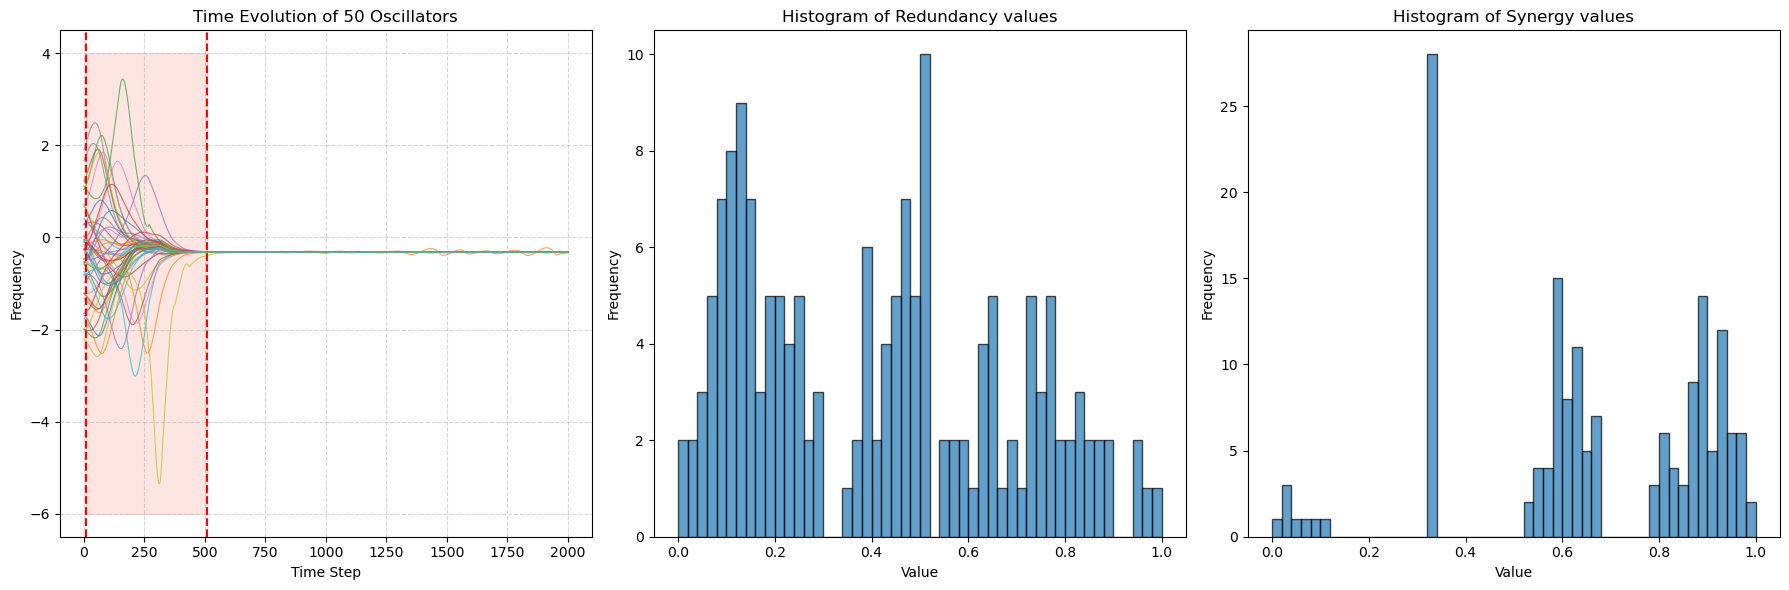

In [62]:
# Normalize all the values so that the S and R values are all positive 
# and the maximum R and S are 1 and minimum 0.
R_values = pd.DataFrame(df_oscillators.iloc[2, 3], columns=['R_values'])
min_R = R_values.min()
R_values += abs(min_R)
R_values = (R_values - R_values.min()) / (R_values.max() - R_values.min())

S_values = pd.DataFrame(df_oscillators.iloc[2, 4], columns=['S_values'])
min_S = S_values.min()
S_values += abs(min_S)
S_values = (S_values - S_values.min()) / (S_values.max() - S_values.min())

# Create subplots for three figures in one row (time evolution first)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot system dynamics (first subplot)
front_limit = window_step
back_limit = front_limit + window_size

for i in range(frequencies_df.shape[1]):  # Loop through all 50 oscillators
    axes[0].plot(frequencies_df.index, frequencies_df[i], alpha=0.7, linewidth=0.8)

# Highlight window in the time-series plot
axes[0].axvline(x=front_limit, color='red', linestyle='--')
axes[0].axvline(x=back_limit, color='red', linestyle='--')
axes[0].fill_between(range(front_limit, back_limit), -6, 4, color='salmon', alpha=0.2)

axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Time Evolution of 50 Oscillators")
axes[0].grid(True, linestyle="--", alpha=0.5)

# Plot R_values histogram (second subplot)
axes[1].hist(R_values, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel("Value")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Histogram of Redundancy values")

# Plot S_values histogram (third subplot)
axes[2].hist(S_values, bins=50, edgecolor='black', alpha=0.7)
axes[2].set_xlabel("Value")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Histogram of Synergy values")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

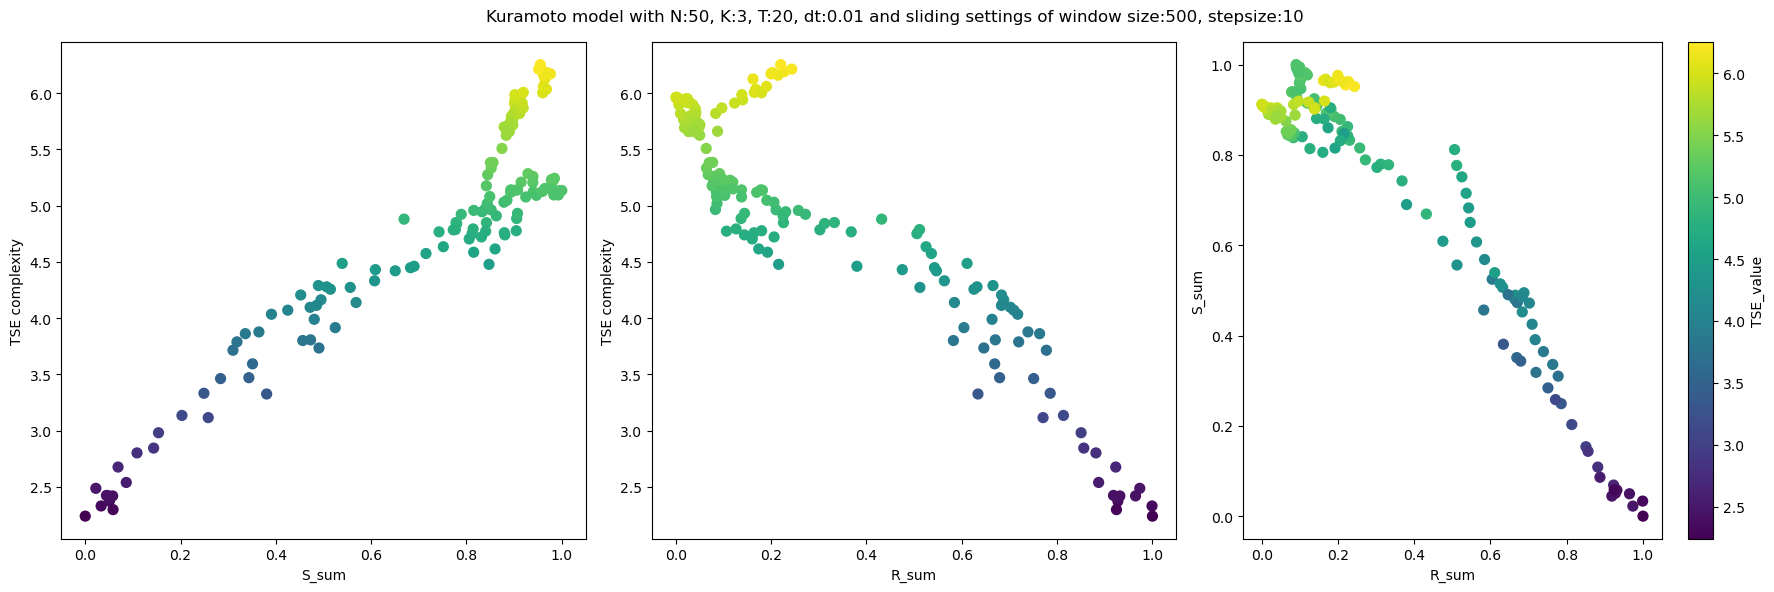

In [46]:
# Create a figure with 1 row and 3 columns for subplots
df = df_oscillators
plt.figure(figsize=(18, 6))

# First subplot for Synergy path
plt.subplot(1, 3, 1)
plt.scatter(df['S_sum'], df['TSE_value'], c=df['TSE_value'], cmap='viridis', s=50)
# for i, (x, y) in enumerate(zip(df['S_sum'], df['TSE_value']), 1):
#    plt.text(x, y, f'c{i}', fontsize=12, ha='right')
plt.xlabel('S_sum')
plt.ylabel('TSE complexity')

# Second subplot for Redundancy path
plt.subplot(1, 3, 2)
plt.scatter(df['R_sum'], df['TSE_value'], c=df['TSE_value'], cmap='viridis', s=50)
#for i, (x, y) in enumerate(zip(df['R_sum'], df['TSE_value']), 1):
#    plt.text(x, y, f'c{i}', fontsize=12, ha='right')
plt.xlabel('R_sum')
plt.ylabel('TSE complexity')

# Third subplot for Redundancy vs Synergy path
plt.subplot(1, 3, 3)
plt.scatter(df['R_sum'], df['S_sum'], c=df['TSE_value'], cmap='viridis', s=50)
#for i, (x, y) in enumerate(zip(df['R_sum'], df['S_sum']), 1):
#    plt.text(x, y, f'c{i}', fontsize=12, ha='right')
plt.colorbar(label='TSE_value')
plt.xlabel('R_sum')
plt.ylabel('S_sum')

# Adjust layout to avoid overlap and display the plot
plt.suptitle(f'Kuramoto model with N:{N}, K:{K}, T:{T}, dt:{dt} and sliding settings of window size:{window_size}, stepsize:{window_step}')
plt.tight_layout()
plt.show()


Visualize result as time evoluted GIF and as static plot

MovieWriter imagemagick unavailable; using Pillow instead.


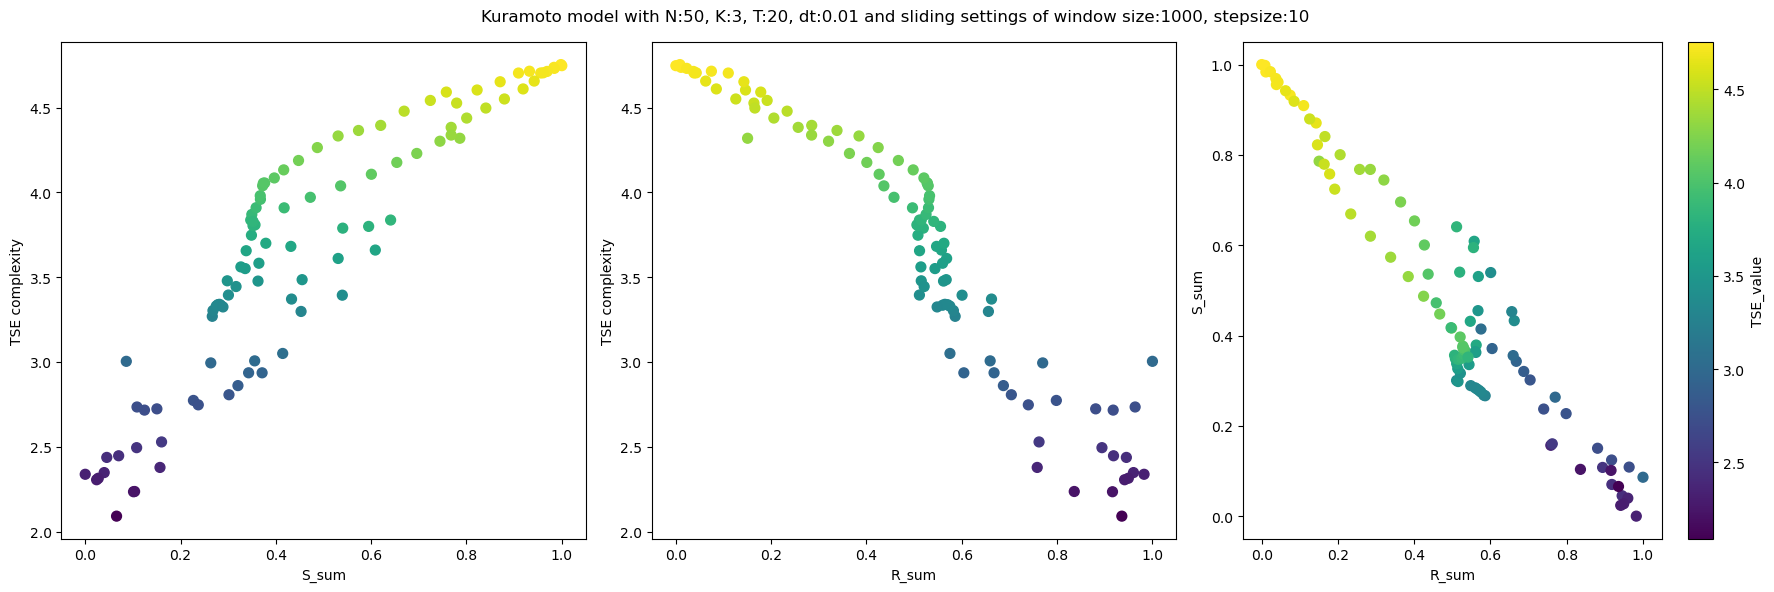

In [29]:
# Create a figure with 1 row and 3 columns for subplots
df = df_oscillators
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Create an initial scatter plot to use for colorbar
scatter = axes[2].scatter(df['R_sum'], df['S_sum'], c=df['TSE_value'], cmap='viridis', s=50)

# Add colorbar only once (after the first plot is created)
cbar = plt.colorbar(scatter, ax=axes[2], label='TSE_value')

# Function to update the plot at each timestep
def update_plot(i):
    # Clear the previous plots
    for ax in axes:
        ax.clear()
    
    # Extract data for the current timestep
    x1, y1, c1 = df['S_sum'][i], df['TSE_value'][i], df['TSE_value'][i]
    x2, y2, c2 = df['R_sum'][i], df['TSE_value'][i], df['TSE_value'][i]
    x3, y3, c3 = df['R_sum'][i], df['S_sum'][i], df['TSE_value'][i]

    # First subplot for Synergy path
    axes[0].scatter(df['S_sum'][:i+1], df['TSE_value'][:i+1], c=df['TSE_value'][:i+1], cmap='viridis', s=50)
    axes[0].set_xlabel('S_sum')
    axes[0].set_ylabel('TSE complexity')
    
    # Second subplot for Redundancy path
    axes[1].scatter(df['R_sum'][:i+1], df['TSE_value'][:i+1], c=df['TSE_value'][:i+1], cmap='viridis', s=50)
    axes[1].set_xlabel('R_sum')
    axes[1].set_ylabel('TSE complexity')
    
    # Third subplot for Redundancy vs Synergy path
    scatter = axes[2].scatter(df['R_sum'][:i+1], df['S_sum'][:i+1], c=df['TSE_value'][:i+1], cmap='viridis', s=50)
    axes[2].set_xlabel('R_sum')
    axes[2].set_ylabel('S_sum')

    # Set the main title
    plt.suptitle(f'Kuramoto model with N:{N}, K:{K}, T:{T}, dt:{dt} and sliding settings of window size:{window_size}, stepsize:{window_step}')

# Create the animation
ani = animation.FuncAnimation(fig, update_plot, frames=len(df), repeat=False)

# Save the animation as a GIF
ani.save('Figures\\TSE_kuramoto2.gif', writer='imagemagick', fps=5)

# Show the plot
plt.tight_layout()
plt.show()


MovieWriter imagemagick unavailable; using Pillow instead.


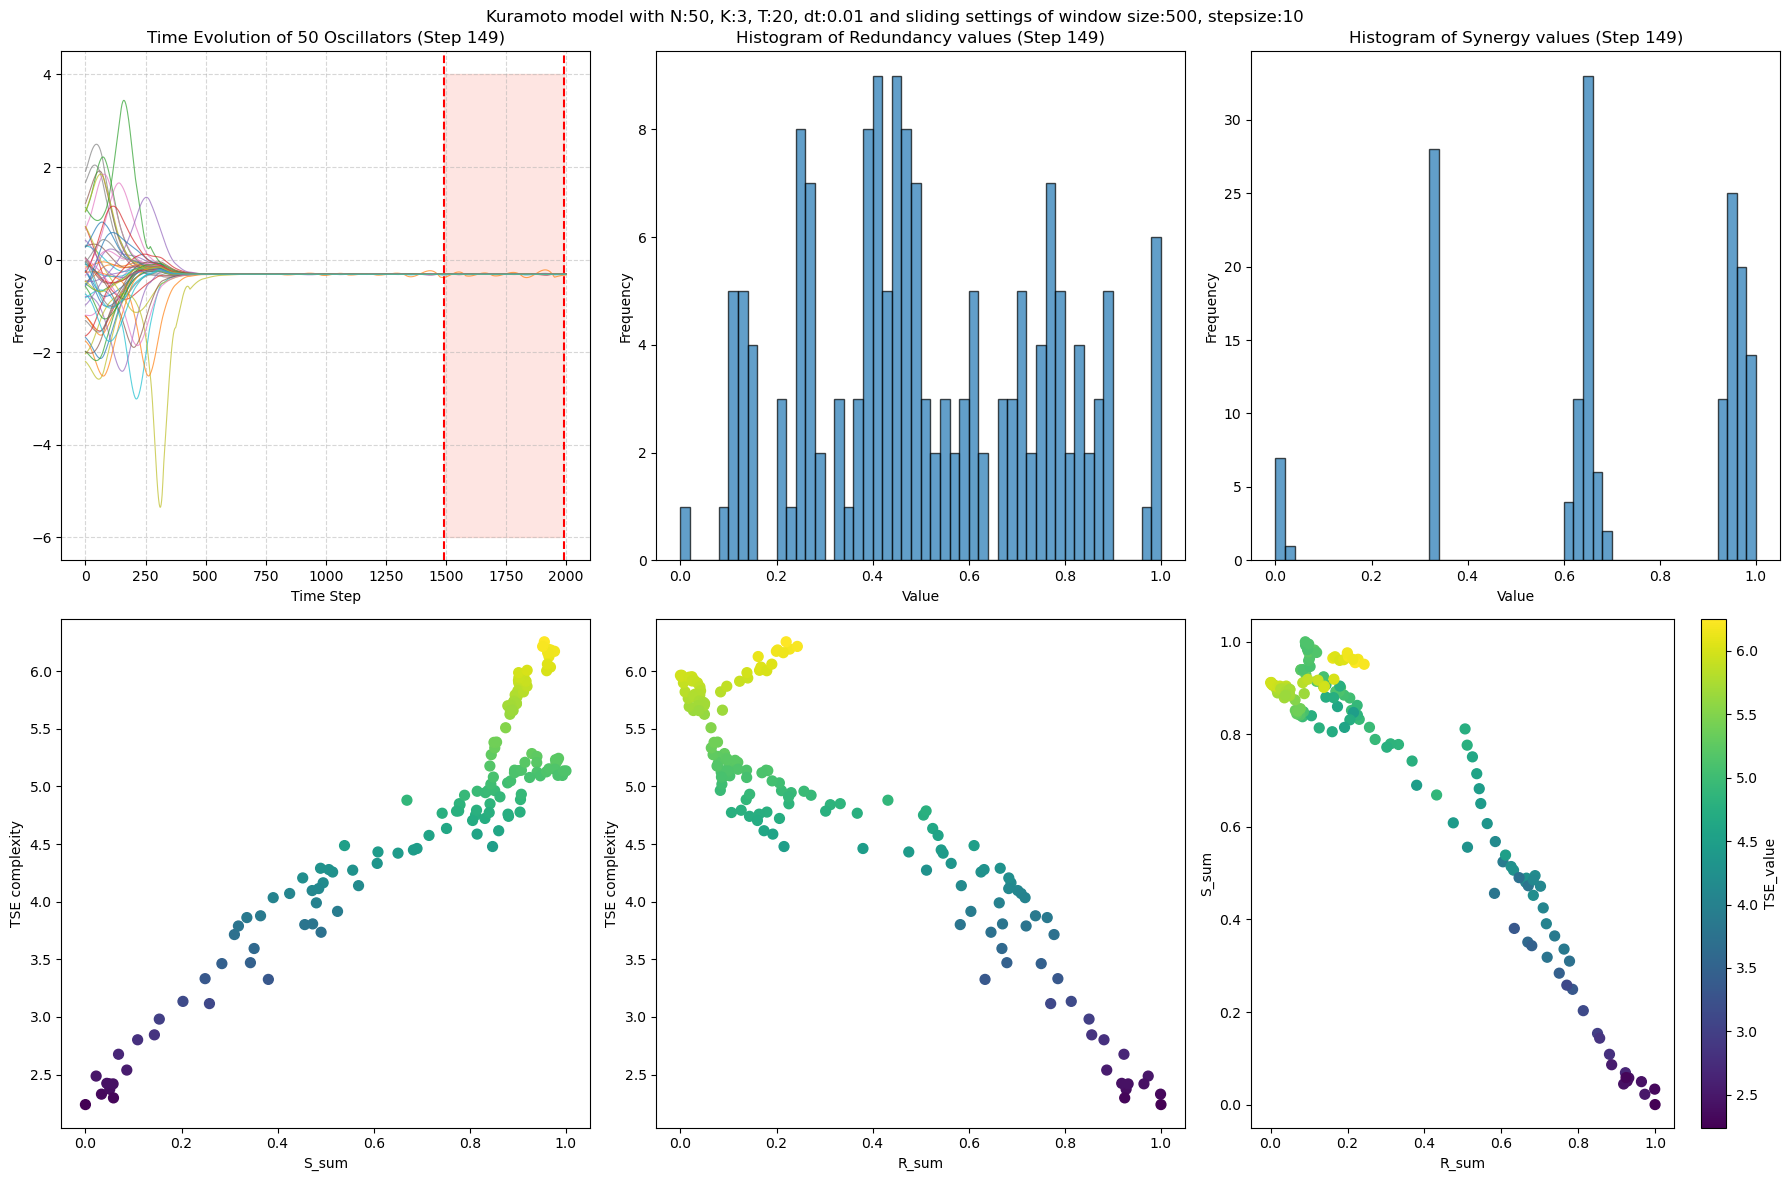

In [ ]:
# Initialize figure and axes (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns

# Create the initial scatter plot to use for colorbar (third row)
scatter = axes[1, 2].scatter(df['R_sum'], df['S_sum'], c=df['TSE_value'], cmap='viridis', s=50)
cbar = plt.colorbar(scatter, ax=axes[1, 2], label='TSE_value')

# Function to update the plots at each timestep
def update_plot(i):
    # Clear previous plots
    for ax in axes.flat:
        ax.clear()

    # Define window limits for time evolution plot
    front_limit = i * window_step
    back_limit = front_limit + window_size

    # 1️⃣ Update Time Evolution Plot (First subplot)
    for j in range(frequencies_df.shape[1]):  # Loop through 50 oscillators
        axes[0, 0].plot(frequencies_df.index, frequencies_df[j], alpha=0.7, linewidth=0.8)

    # Highlight moving window
    axes[0, 0].axvline(x=front_limit, color='red', linestyle='--')
    axes[0, 0].axvline(x=back_limit, color='red', linestyle='--')
    axes[0, 0].fill_between(range(front_limit, back_limit), -6, 4, color='salmon', alpha=0.2)

    axes[0, 0].set_xlabel("Time Step")
    axes[0, 0].set_ylabel("Frequency")
    axes[0, 0].set_title(f"Time Evolution of 50 Oscillators (Step {i})")
    axes[0, 0].grid(True, linestyle="--", alpha=0.5)

    # 2️⃣ Normalize R_values for the current row
    R_values = pd.DataFrame(df_oscillators.iloc[i, 3], columns=['R_values'])
    min_R = R_values.min()
    R_values += abs(min_R)
    R_values = (R_values - R_values.min()) / (R_values.max() - R_values.min())

    # Plot histogram for R_values (Second subplot)
    axes[0, 1].hist(R_values, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel("Value")
    axes[0, 1].set_ylabel("Frequency")
    axes[0, 1].set_title(f"Histogram of Redundancy values (Step {i})")

    # 3️⃣ Normalize S_values for the current row
    S_values = pd.DataFrame(df_oscillators.iloc[i, 4], columns=['S_values'])
    min_S = S_values.min()
    S_values += abs(min_S)
    S_values = (S_values - S_values.min()) / (S_values.max() - S_values.min())

    # Plot histogram for S_values (Third subplot)
    axes[0, 2].hist(S_values, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 2].set_xlabel("Value")
    axes[0, 2].set_ylabel("Frequency")
    axes[0, 2].set_title(f"Histogram of Synergy values (Step {i})")
    
    # 4️⃣ Update scatter plot for Synergy path (Second row, first subplot)
    axes[1, 0].scatter(df['S_sum'][:i+1], df['TSE_value'][:i+1], c=df['TSE_value'][:i+1], cmap='viridis', s=50)
    axes[1, 0].set_xlabel('S_sum')
    axes[1, 0].set_ylabel('TSE complexity')
    
    # 5️⃣ Update scatter plot for Redundancy path (Second row, second subplot)
    axes[1, 1].scatter(df['R_sum'][:i+1], df['TSE_value'][:i+1], c=df['TSE_value'][:i+1], cmap='viridis', s=50)
    axes[1, 1].set_xlabel('R_sum')
    axes[1, 1].set_ylabel('TSE complexity')

    # 6️⃣ Update scatter plot for Redundancy vs Synergy path (Second row, third subplot)
    scatter = axes[1, 2].scatter(df['R_sum'][:i+1], df['S_sum'][:i+1], c=df['TSE_value'][:i+1], cmap='viridis', s=50)
    axes[1, 2].set_xlabel('R_sum')
    axes[1, 2].set_ylabel('S_sum')

    # Set the main title for the animation
    plt.suptitle(f'Kuramoto model with N:{N}, K:{K}, T:{T}, dt:{dt} and sliding settings of window size:{window_size}, stepsize:{window_step}')

    # Adjust layout for proper spacing
    plt.tight_layout()

# Create the animation (one frame per row in df_oscillators)
ani = animation.FuncAnimation(fig, update_plot, frames=len(df_oscillators), repeat=False)

# Save the animation as a GIF
ani.save('Figures/TSE_kuramoto_animation.gif', writer='imagemagick', fps=5)

# Show the animation
plt.show()


MovieWriter imagemagick unavailable; using Pillow instead.


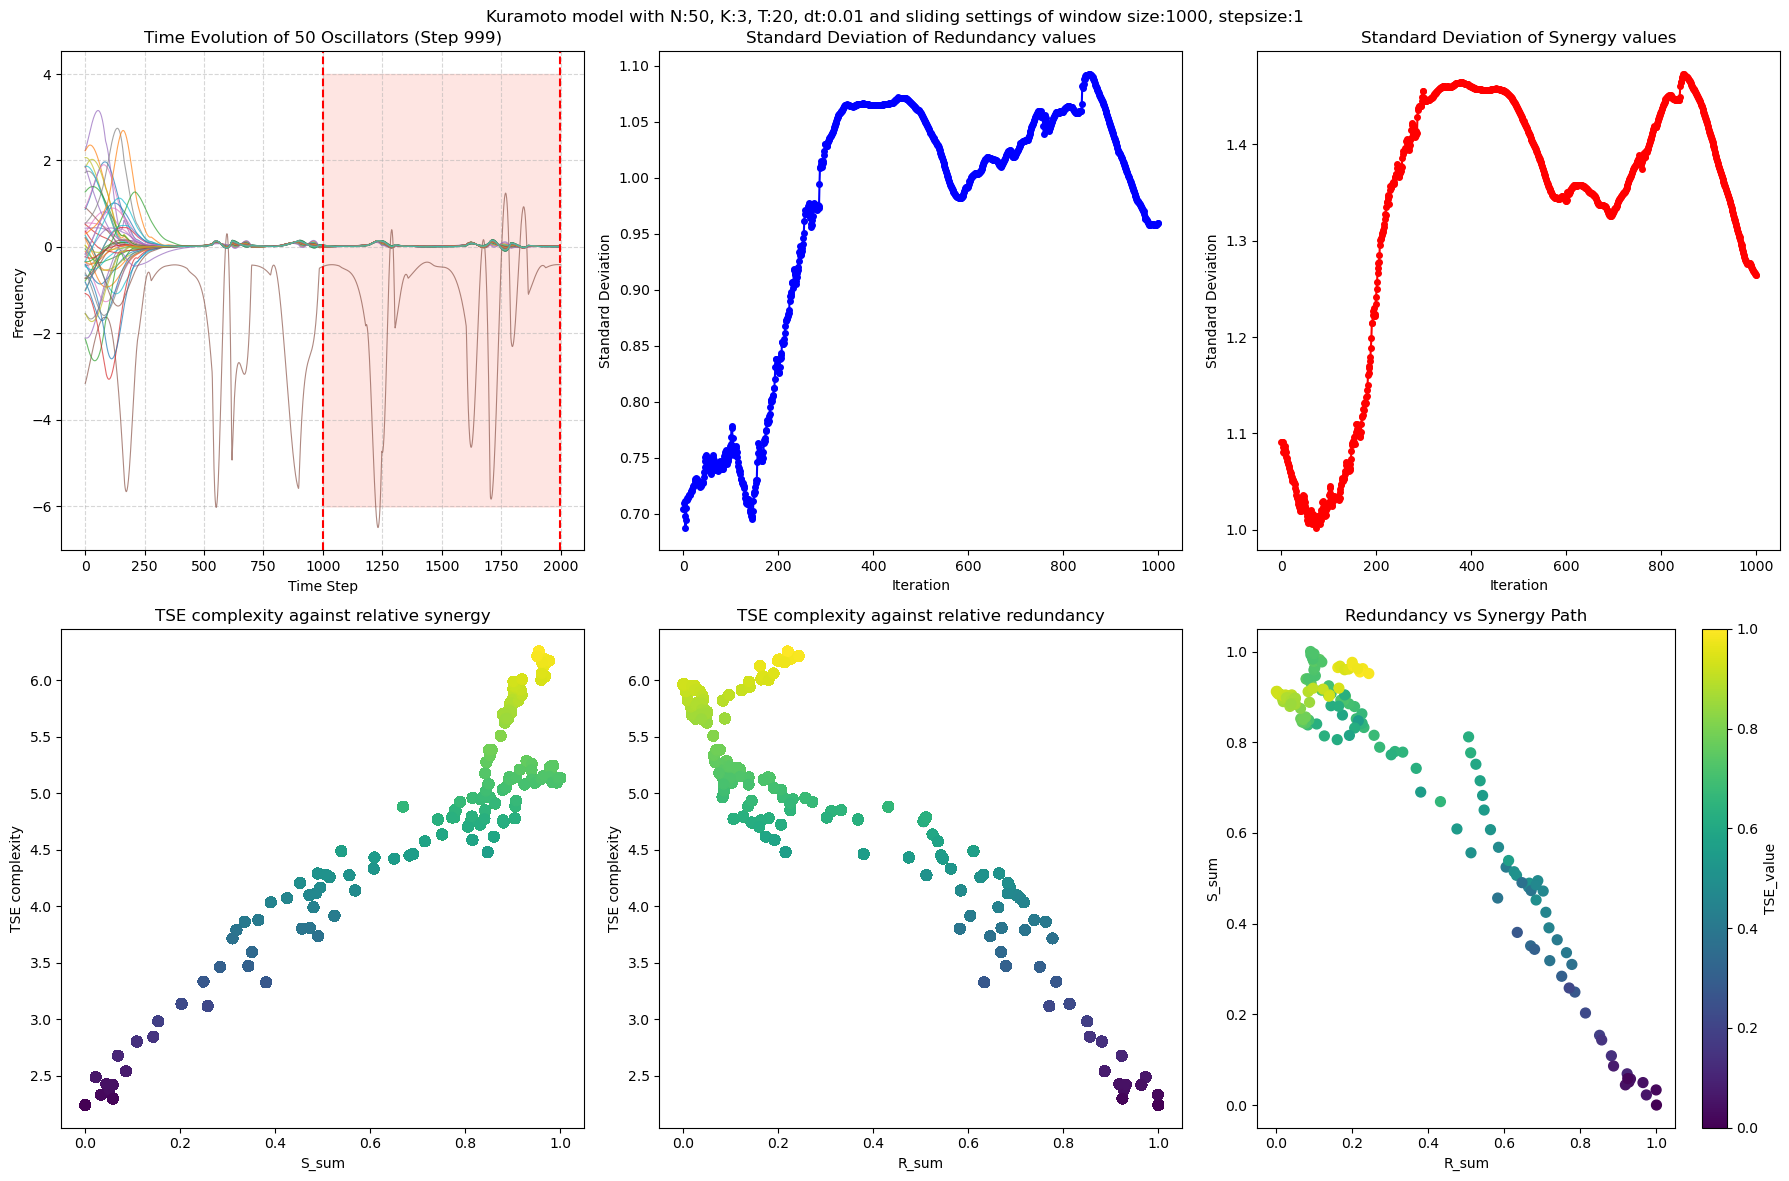

In [79]:
# Initialize figure and axes (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns

# Create lists to store standard deviations for R_values and S_values
R_stds = []
S_stds = []

# Create the initial scatter plot for redundancy vs synergy to use for the colorbar
scatter = axes[1, 2].scatter([], [], c=[], cmap='viridis', s=50)
cbar = plt.colorbar(scatter, ax=axes[1, 2], label='TSE_value')

# Function to update the plots at each timestep
def update_plot(i):
    # Clear previous plots for the first row (but not the standard deviation plots)
    for ax in axes[0, :]:
        ax.clear()

    # Define window limits for time evolution plot
    front_limit = i * window_step
    back_limit = front_limit + window_size

    # 1️⃣ Update Time Evolution Plot (First subplot)
    for j in range(frequencies_df.shape[1]):  # Loop through 50 oscillators
        axes[0, 0].plot(frequencies_df.index, frequencies_df[j], alpha=0.7, linewidth=0.8)

    # Highlight moving window
    axes[0, 0].axvline(x=front_limit, color='red', linestyle='--')
    axes[0, 0].axvline(x=back_limit, color='red', linestyle='--')
    axes[0, 0].fill_between(range(front_limit, back_limit), -6, 4, color='salmon', alpha=0.2)

    axes[0, 0].set_xlabel("Time Step")
    axes[0, 0].set_ylabel("Frequency")
    axes[0, 0].set_title(f"Time Evolution of 50 Oscillators (Step {i})")
    axes[0, 0].grid(True, linestyle="--", alpha=0.5)

    # 2️⃣ Calculate and store the standard deviation for R_values (Second subplot)
    R_values = pd.DataFrame(df_oscillators.iloc[i, 3], columns=['R_values'])
    R_std = R_values.std().values[0]  # Standard deviation of R_values
    R_stds.append(R_std)  # Append the R_std for this timestep

    axes[0, 1].plot(range(len(R_stds)), R_stds, 'bo-', label="R_values Std", markersize=4)
    axes[0, 1].set_xlabel("Iteration")
    axes[0, 1].set_ylabel("Standard Deviation")
    axes[0, 1].set_title("Standard Deviation of Redundancy values")

    # 3️⃣ Calculate and store the standard deviation for S_values (Third subplot)
    S_values = pd.DataFrame(df_oscillators.iloc[i, 4], columns=['S_values'])
    S_std = S_values.std().values[0]  # Standard deviation of S_values
    S_stds.append(S_std)  # Append the S_std for this timestep

    axes[0, 2].plot(range(len(S_stds)), S_stds, 'ro-', label="S_values Std", markersize=4)
    axes[0, 2].set_xlabel("Iteration")
    axes[0, 2].set_ylabel("Standard Deviation")
    axes[0, 2].set_title("Standard Deviation of Synergy values")

    # 4️⃣ Update scatter plot for Synergy path (Second row, first subplot)
    axes[1, 0].scatter(df['S_sum'][:i+1], df['TSE_value'][:i+1], c=df['TSE_value'][:i+1], cmap='viridis', s=50)
    axes[1, 0].set_xlabel('S_sum')
    axes[1, 0].set_ylabel('TSE complexity')
    axes[1, 0].set_title("TSE complexity against relative synergy")

    # 5️⃣ Update scatter plot for Redundancy path (Second row, second subplot)
    axes[1, 1].scatter(df['R_sum'][:i+1], df['TSE_value'][:i+1], c=df['TSE_value'][:i+1], cmap='viridis', s=50)
    axes[1, 1].set_xlabel('R_sum')
    axes[1, 1].set_ylabel('TSE complexity')
    axes[1, 1].set_title("TSE complexity against relative redundancy")

    # 6️⃣ Update scatter plot for Redundancy vs Synergy path (Second row, third subplot)
    axes[1, 2].clear()  # Clear only the scatter plot (NOT the colorbar)
    scatter = axes[1, 2].scatter(df['R_sum'][:i+1], df['S_sum'][:i+1], c=df['TSE_value'][:i+1], cmap='viridis', s=50)
    axes[1, 2].set_xlabel('R_sum')
    axes[1, 2].set_ylabel('S_sum')
    axes[1, 2].set_title("Redundancy vs Synergy Path")

    # Set the main title for the animation
    plt.suptitle(f'Kuramoto model with N:{N}, K:{K}, T:{T}, dt:{dt} and sliding settings of window size:{window_size}, stepsize:{window_step}')

    # Adjust layout for proper spacing
    plt.tight_layout()

# Create the animation (one frame per row in df_oscillators)
ani = animation.FuncAnimation(fig, update_plot, frames=len(df_oscillators), repeat=False)

# Save the animation as a GIF
ani.save('Figures/TSE_kuramoto_animation.gif', writer='imagemagick', fps=5)

# Show the animation
plt.show()

Generate larger number of Kuramoto simulations to confirm expected behaviour

In [ ]:
# Initialize an empty list to store dataframes
all_dfs = []

for i in range(30):
    print(f"Running simulation {i+1}/10...")

    # Generate Kuramoto timeseries
    sol, omega, frequencies = simulate_kuramoto(N=50, K=3, T=20, dt=0.01)

    # Convert to right data format
    frequencies_df = pd.DataFrame(frequencies).transpose()

    # Obtain information metrics
    df_oscillators = interactions_values_relative(frequencies_df, window_size=1000, window_step=10, dimension_max=4, dimension_tot=8)

    # Add a column to track which run the data came from
    df_oscillators['Run'] = i + 1

    # Store the dataframe in the list
    all_dfs.append(df_oscillators)

# Example of saving all DataFrames in the list as separate CSVs (optional)
for idx, df in enumerate(all_dfs):
    df.to_csv(f"Data\\Kuramoto\\df_oscillators_run_{idx+1}.csv", index=False)

Running simulation 11/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 12/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 13/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 14/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 15/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 16/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 17/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 18/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 19/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 20/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 21/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 22/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 23/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 24/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 25/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 26/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 27/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 28/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 29/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 30/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 31/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 32/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 33/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 34/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 35/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 36/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 37/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 38/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 39/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 40/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_23840\3853564888.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


In [180]:
# Import the data
file_list = glob.glob("Data\\Kuramoto\\df_oscillators_run_*.csv")

# Sort files to ensure they are loaded in the correct order
file_list.sort()  

# Initialize an empty list to store the imported DataFrames
all_dfs = []

# Loop through each file and read it into a DataFrame
for file in file_list:
    df = pd.read_csv(file)
    all_dfs.append(df)

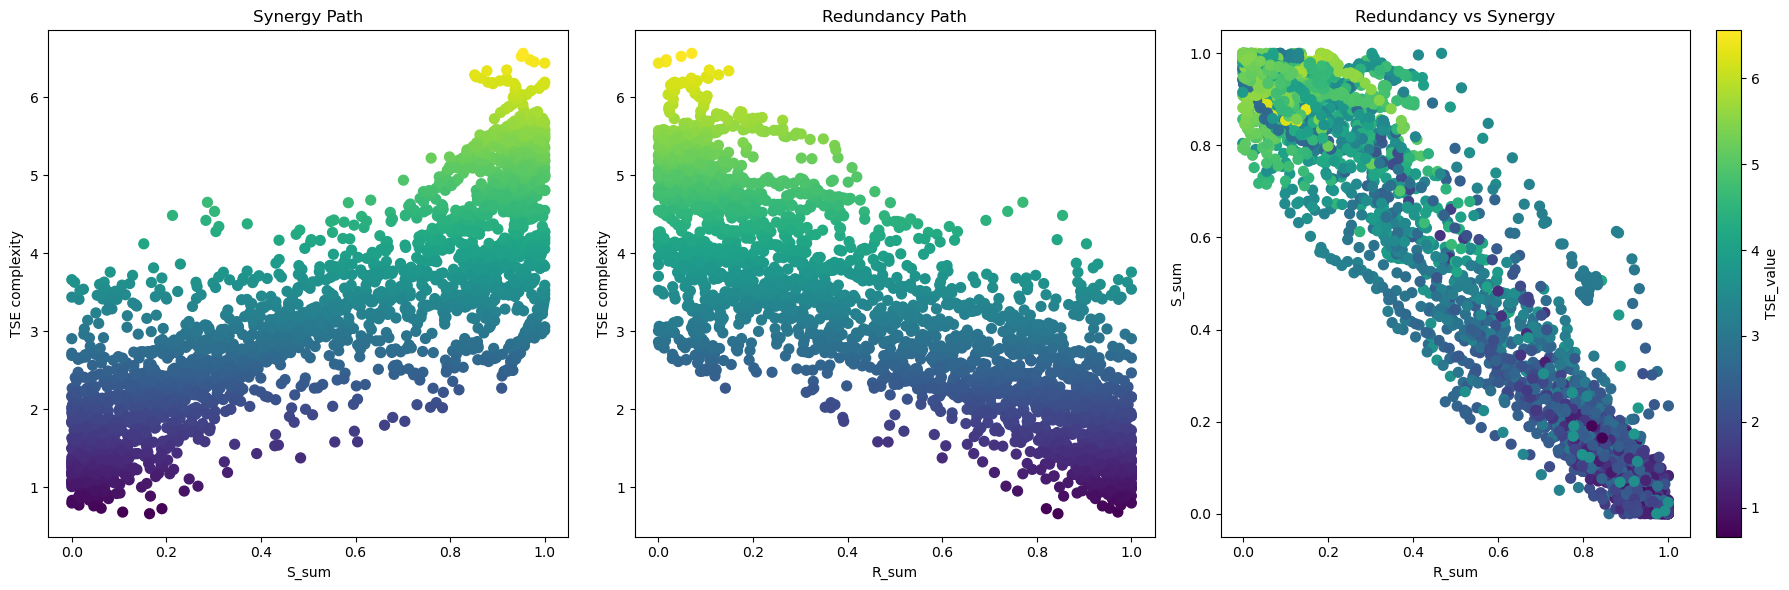

In [181]:
# Create a figure with 1 row and 3 columns for subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Normalize colors based on TSE_value
norm = mcolors.Normalize(vmin=min(df['TSE_value'].min() for df in all_dfs), 
                         vmax=max(df['TSE_value'].max() for df in all_dfs))
cmap = plt.cm.viridis

# Loop through the dataframes
for df in all_dfs:
    # First subplot for Synergy path (S_sum vs TSE_value)
    sc1 = axes[0].scatter(df['S_sum'], df['TSE_value'], c=df['TSE_value'], cmap=cmap, norm=norm, s=50)
    axes[0].set_xlabel('S_sum')
    axes[0].set_ylabel('TSE complexity')
    axes[0].set_title('Synergy Path')

    # Second subplot for Redundancy path (R_sum vs TSE_value)
    sc2 = axes[1].scatter(df['R_sum'], df['TSE_value'], c=df['TSE_value'], cmap=cmap, norm=norm, s=50)
    axes[1].set_xlabel('R_sum')
    axes[1].set_ylabel('TSE complexity')
    axes[1].set_title('Redundancy Path')

    # Third subplot for Redundancy vs Synergy path (R_sum vs S_sum)
    sc3 = axes[2].scatter(df['R_sum'], df['S_sum'], c=df['TSE_value'], cmap=cmap, norm=norm, s=50)
    axes[2].set_xlabel('R_sum')
    axes[2].set_ylabel('S_sum')
    axes[2].set_title('Redundancy vs Synergy')

# Create a colorbar and place it to the right of the third plot
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes[2], location='right', fraction=0.05, pad=0.05)
cbar.set_label('TSE_value')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

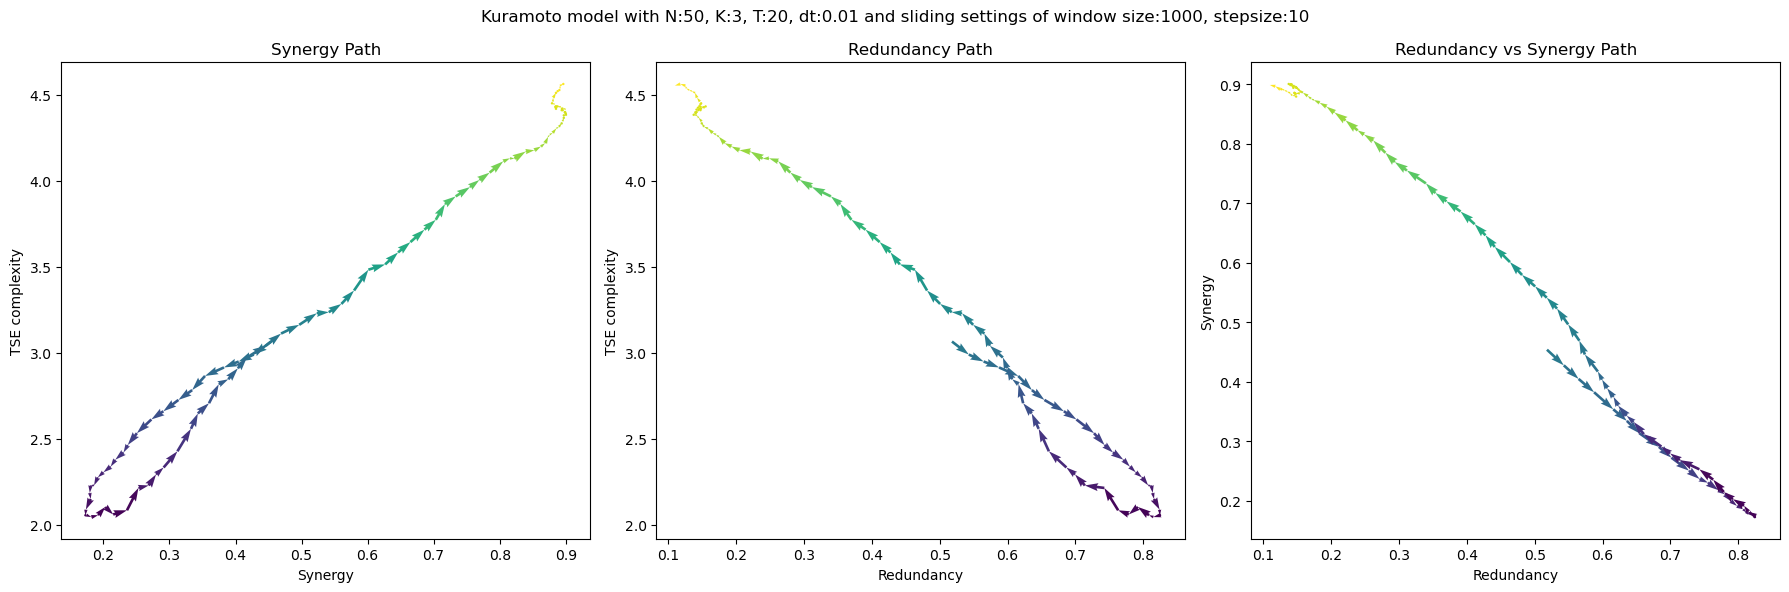

In [185]:
# Create a figure with 1 row and 3 columns for subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Compute the average of the simulations
df_averaged = sum(all_dfs) / len(all_dfs)
df = df_averaged

# Extract data
x1, y1, c1 = df['S_sum'], df['TSE_value'], df['TSE_value']
x2, y2, c2 = df['R_sum'], df['TSE_value'], df['TSE_value']
x3, y3, c3 = df['R_sum'], df['S_sum'], df['TSE_value']

# Compute arrow directions (differences between consecutive points)
dx1, dy1 = np.diff(x1), np.diff(y1)
dx2, dy2 = np.diff(x2), np.diff(y2)
dx3, dy3 = np.diff(x3), np.diff(y3)

# Normalize colors based on TSE_value
norm = mcolors.Normalize(vmin=df['TSE_value'].min(), vmax=df['TSE_value'].max())
cmap = plt.cm.viridis

# First subplot for Synergy path
q1 = axes[0].quiver(x1[:-1], y1[:-1], dx1, dy1, c1[:-1], cmap=cmap, norm=norm, angles='xy', scale_units='xy', scale=1, width=0.005)
axes[0].set_xlabel('Synergy')
axes[0].set_ylabel('TSE complexity')
axes[0].set_title('Synergy Path')

# Second subplot for Redundancy path
q2 = axes[1].quiver(x2[:-1], y2[:-1], dx2, dy2, c2[:-1], cmap=cmap, norm=norm, angles='xy', scale_units='xy', scale=1, width=0.005)
axes[1].set_xlabel('Redundancy')
axes[1].set_ylabel('TSE complexity')
axes[1].set_title('Redundancy Path')

# Third subplot for Redundancy vs Synergy path
q3 = axes[2].quiver(x3[:-1], y3[:-1], dx3, dy3, c3[:-1], cmap=cmap, norm=norm, angles='xy', scale_units='xy', scale=1, width=0.005)
axes[2].set_xlabel('Redundancy')
axes[2].set_ylabel('Synergy')
axes[2].set_title('Redundancy vs Synergy Path')

# Add a single colorbar for all subplots
# cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
# cbar.set_label('TSE_value')

# Adjust layout to avoid overlap and display the plot
plt.suptitle(f'Kuramoto model with N:{N}, K:{K}, T:{T}, dt:{dt} and sliding settings of window size:{window_size}, stepsize:{window_step}')
plt.tight_layout()
plt.show()


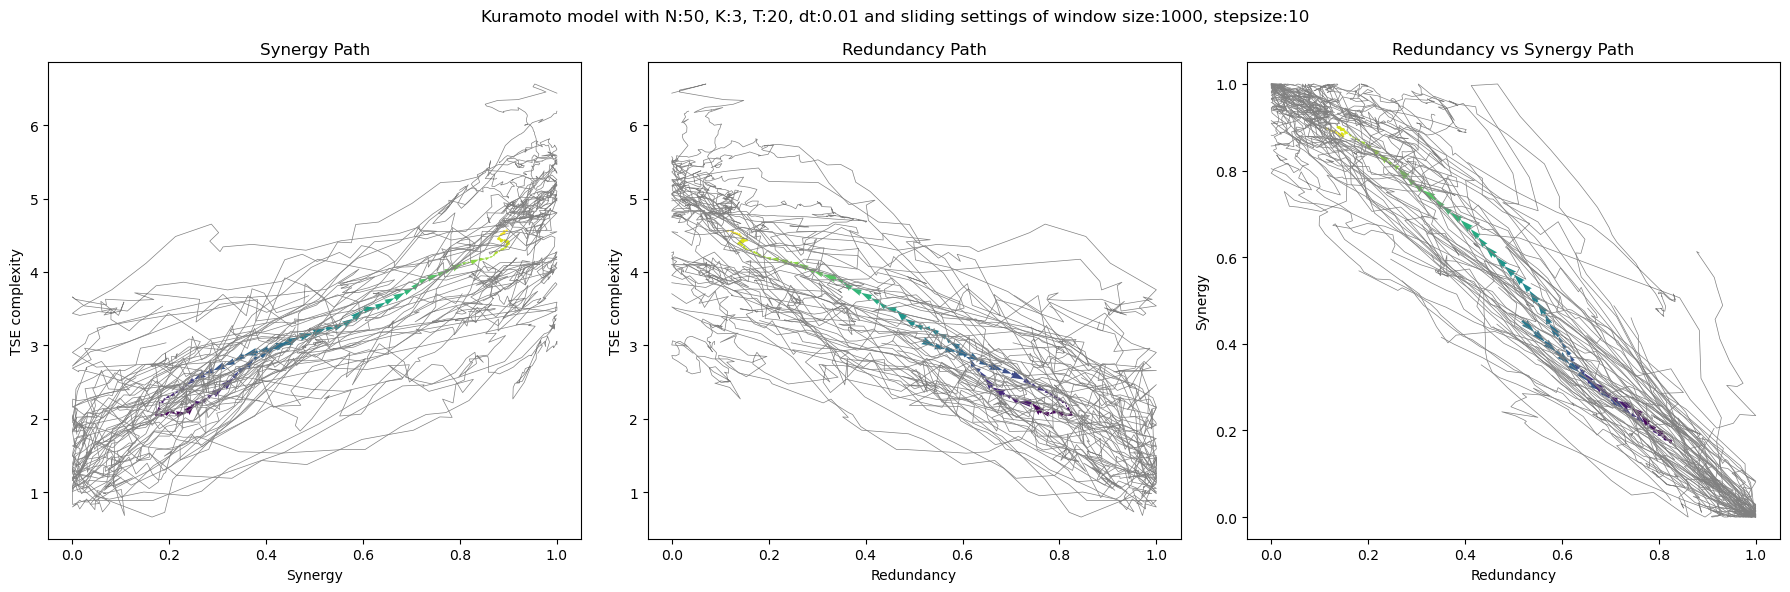

In [183]:
# Create a figure with 1 row and 3 columns for subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Compute the average of the simulations
df_averaged = sum(all_dfs) / len(all_dfs)
df = df_averaged

# Extract data
x1, y1, c1 = df['S_sum'], df['TSE_value'], df['TSE_value']
x2, y2, c2 = df['R_sum'], df['TSE_value'], df['TSE_value']
x3, y3, c3 = df['R_sum'], df['S_sum'], df['TSE_value']

# Compute arrow directions (differences between consecutive points)
dx1, dy1 = np.diff(x1), np.diff(y1)
dx2, dy2 = np.diff(x2), np.diff(y2)
dx3, dy3 = np.diff(x3), np.diff(y3)

# Normalize colors based on TSE_value
norm = mcolors.Normalize(vmin=df['TSE_value'].min(), vmax=df['TSE_value'].max())
cmap = plt.cm.viridis

# First subplot for Synergy path
for df in all_dfs:
    # First subplot for Synergy path (S_sum vs TSE_value)
    axes[0].plot(df['S_sum'], df['TSE_value'], color='grey', linewidth=0.5)
q1 = axes[0].quiver(x1[:-1], y1[:-1], dx1, dy1, c1[:-1], cmap=cmap, norm=norm, angles='xy', scale_units='xy', scale=1, width=0.005, alpha=1)
axes[0].set_xlabel('Synergy')
axes[0].set_ylabel('TSE complexity')
axes[0].set_title('Synergy Path')

# Second subplot for Redundancy path
for df in all_dfs:
    # First subplot for Synergy path (S_sum vs TSE_value)
    axes[1].plot(df['R_sum'], df['TSE_value'], color='grey', linewidth=0.5)
q2 = axes[1].quiver(x2[:-1], y2[:-1], dx2, dy2, c2[:-1], cmap=cmap, norm=norm, angles='xy', scale_units='xy', scale=1, width=0.005, alpha=1)
axes[1].set_xlabel('Redundancy')
axes[1].set_ylabel('TSE complexity')
axes[1].set_title('Redundancy Path')

# Third subplot for Redundancy vs Synergy path
for df in all_dfs:
    # First subplot for Synergy path (S_sum vs TSE_value)
    axes[2].plot(df['R_sum'], df['S_sum'], color='grey', linewidth=0.5)
q3 = axes[2].quiver(x3[:-1], y3[:-1], dx3, dy3, c3[:-1], cmap=cmap, norm=norm, angles='xy', scale_units='xy', scale=1, width=0.005, alpha=1)
axes[2].set_xlabel('Redundancy')
axes[2].set_ylabel('Synergy')
axes[2].set_title('Redundancy vs Synergy Path')

# Add a single colorbar for all subplots
# cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
# cbar.set_label('TSE_value')

# Adjust layout to avoid overlap and display the plot
plt.suptitle(f'Kuramoto model with N:{N}, K:{K}, T:{T}, dt:{dt} and sliding settings of window size:{window_size}, stepsize:{window_step}')
plt.tight_layout()
plt.show()
